In [35]:
import numpy as np
import re
import matplotlib.pyplot as plt
import random
from pathlib import Path
from collections import defaultdict
from random import sample

# High level plan

## Pre-processing steps

- build out 200-word paragraph
- get unique words from paragraph
- remove punctuations
- for every word in vocab, grab words +/- 2 words around it
- for every word in vocab, get random words that are not vocab word. Get double neg words

In [ ]:
# # Read the entire file
# raw = Path("../data/wiki.train.tokens").resolve().read_text(encoding="utf-8")
# lines = raw.splitlines()
# filtered = [line for line in lines if "=" not in line]
# corpus = " ".join(filtered)

In [37]:
# Simple corpus
corpus = """All the world's a stage, and everyone plays a part. They each have their entrances and exits. One person over a lifetime takes on many roles. First comes the infant, crying and vomiting in the nurse's arms. Then the complaining schoolboy, dragging his backpack as he reluctantly makes his way to class. Next the lover, sighing like a furnace, composing a sad song to his beloved's eyebrow. Then the soldier, full of strange oaths and with a beard like a leopard's, jealous of honor, quick to quarrel, chasing fleeting reputation even in the cannon's blast. Then comes the judge, well stuffed with capon, stern and neatly trimmed, full of wise sayings and examples. After that the old man in slipping slippers, spectacles perched on his nose and a pouch at his side, his snug leggings now too wide, and his strong voice turned to a high tone. Finally comes the last stage: a second childhood and total oblivion, devoid of everything."""

In [38]:
# remove anything that isn’t an English letter or whitespace
corpus = re.sub(r"[^a-zA-Z\s]", "", corpus.lower())
corpus = re.sub(r"\s+", " ", corpus)

In [39]:
corpus_words = corpus.split(" ")

In [40]:
# build out vocabulary
vocab = set(sorted(corpus_words))

In [41]:
win = 2

positions = [i for i, w in enumerate(corpus_words) if w in vocab]
c_pos_dict = defaultdict(list)
n = len(corpus_words)

for i in positions:
    w = corpus_words[i]
    left = corpus_words[max(0, i - win) : i]
    right = corpus_words[i + 1 : min(n, i + 1 + win)]
    c_pos_dict[w].extend(left + right)

In [42]:
num_negative_samples = 8
c_pos_sets = {w: set(ctx) for w, ctx in c_pos_dict.items()}

c_neg_dict = {}
for w in vocab:
    forbidden = c_pos_sets[w] | {w}
    # one O(V) set‐difference, then O(k) sample
    candidates = list(vocab - forbidden)
    c_neg_dict[w] = sample(candidates, num_negative_samples)

## Implementation

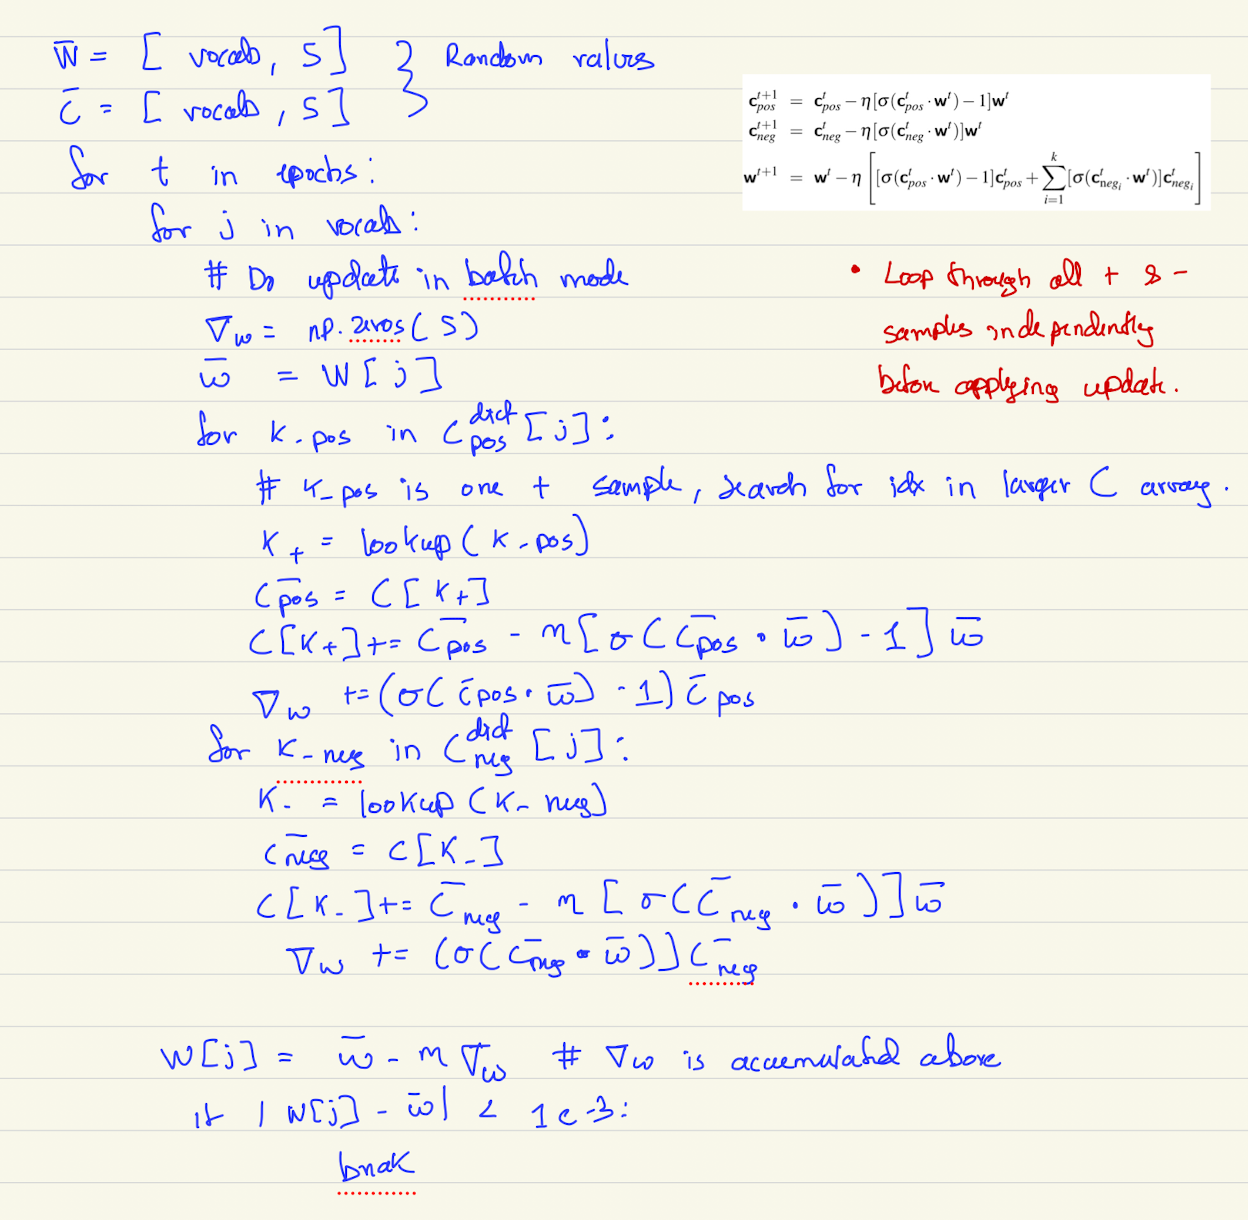

Pseudo code:

```text
# Hyperparameters
dimension     = 5                # your embedding size
learning_rate = eta              # your step size
max_epochs    = T                # maximum number of passes
epsilon       = 1e-3             # convergence threshold

# Assume:
#   vocab  = list of all words (strings)
#   c_pos  = dict: word -> list of its positive context words
#   c_neg  = dict: word -> list of its negative sample words

# W and C are mappings from each word to its embedding vector:
#   W[word] is the target‐word embedding (shape: [dimension])
#   C[word] is the context‐word embedding (shape: [dimension])

W = np.ones(words, dimension) * 0.01
C = np.ones(words, dimension) * 0.01

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

for epoch in range(max_epochs):
    max_update = 0.0

    for target in vocab:
        # snapshot the old target vector and zero out its gradient accumulator
        w_old  = W[target].copy()
        grad_w = np.zeros(dimension)

        # 1) Update all positive contexts (Eq. 6.38) and accumulate grad_w
        for pos_word in c_pos[target]:
            c_old = C[pos_word].copy()
            s     = sigmoid(c_old.dot(w_old))
            C[pos_word] = c_old - learning_rate * (s - 1.0) * w_old
            # accumulate positive term for w‐gradient
            grad_w     += (s - 1.0) * c_old

        # 2) Update all negative contexts (Eq. 6.39) and accumulate grad_w
        for neg_word in c_neg[target]:
            c_old = C[neg_word].copy()
            s     = sigmoid(c_old.dot(w_old))
            C[neg_word] = c_old - learning_rate * (s) * w_old
            # accumulate negative term for w‐gradient
            grad_w     += s * c_old

        # 3) update of the target embedding (Eq. 6.40)
        W[target] = w_old - learning_rate * grad_w

        # track the maximum change for early stopping
        delta = np.max(np.abs(W[target] - w_old))
        if delta > max_update:
            max_update = delta

    if max_update < epsilon:
        break

```

In [43]:
dimension = 15
learning_rate = 0.025
max_epochs = 100
epsilon = 1e-3

In [44]:
random.seed(42)
np.random.seed(42)

W = np.random.rand(len(vocab), dimension).astype(np.float32)
C = np.random.rand(len(vocab), dimension).astype(np.float32)

In [45]:
W, C

(array([[0.37454012, 0.9507143 , 0.7319939 , ..., 0.83244264, 0.21233912,
         0.18182497],
        [0.1834045 , 0.30424225, 0.52475643, ..., 0.5142344 , 0.59241456,
         0.04645041],
        [0.60754484, 0.17052412, 0.06505159, ..., 0.03438852, 0.9093204 ,
         0.25877997],
        ...,
        [0.23464209, 0.39931592, 0.15241602, ..., 0.8260676 , 0.7820281 ,
         0.7087447 ],
        [0.03616038, 0.30312836, 0.26311257, ..., 0.919392  , 0.49696347,
         0.992158  ],
        [0.85142493, 0.20851052, 0.9305952 , ..., 0.40298018, 0.17352451,
         0.6949511 ]], shape=(112, 15), dtype=float32),
 array([[0.34609973, 0.9756102 , 0.6409721 , ..., 0.398663  , 0.14637399,
         0.36753443],
        [0.06817231, 0.02581191, 0.13516629, ..., 0.21603818, 0.61958796,
         0.6502011 ],
        [0.15202485, 0.06134963, 0.7807616 , ..., 0.30327514, 0.10104581,
         0.6921613 ],
        ...,
        [0.6616843 , 0.48398936, 0.00531348, ..., 0.51800805, 0.14032452,
  

In [46]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [47]:
training_loss_error = []
vocab = list(vocab)
for t in range(max_epochs):
    for j, target in enumerate(vocab):
        w_old = W[j].copy()
        grad_w = np.zeros(shape=w_old.shape)

        for pos_word in c_pos_dict[target]:
            # Need to get numerical index of word pos_word
            k_plus = vocab.index(pos_word)

            c_old = C[k_plus].copy()
            s = sigmoid(c_old.dot(w_old))
            C[k_plus] = c_old - learning_rate * (s - 1.0) * w_old
            # accumulate positive term for w‐gradient
            grad_w += (s - 1.0) * c_old

        for neg_word in c_neg_dict[target]:
            k_minus = vocab.index(neg_word)

            c_old = C[k_minus].copy()
            s = sigmoid(c_old.dot(w_old))
            C[k_minus] = c_old - learning_rate * (s) * w_old
            # accumulate negative term for w‐gradient
            grad_w += s * c_old

        # 3) update of the target embedding (Eq. 6.40)
        W[j] = w_old - learning_rate * grad_w

        # track the maximum change for early stopping
        delta = np.max(np.abs(W[j] - w_old))

    training_loss_error.append(delta)
    print(f"Epoch {t}: max change {delta:.3E}")
    if delta < epsilon:
        break

Epoch 0: max change 1.141E-01
Epoch 1: max change 9.453E-02
Epoch 2: max change 7.766E-02
Epoch 3: max change 6.442E-02
Epoch 4: max change 5.445E-02
Epoch 5: max change 4.694E-02
Epoch 6: max change 4.188E-02
Epoch 7: max change 3.826E-02
Epoch 8: max change 3.615E-02
Epoch 9: max change 3.454E-02
Epoch 10: max change 3.321E-02
Epoch 11: max change 3.206E-02
Epoch 12: max change 3.104E-02
Epoch 13: max change 3.011E-02
Epoch 14: max change 2.924E-02
Epoch 15: max change 2.840E-02
Epoch 16: max change 2.760E-02
Epoch 17: max change 2.682E-02
Epoch 18: max change 2.607E-02
Epoch 19: max change 2.533E-02
Epoch 20: max change 2.463E-02
Epoch 21: max change 2.394E-02
Epoch 22: max change 2.329E-02
Epoch 23: max change 2.266E-02
Epoch 24: max change 2.207E-02
Epoch 25: max change 2.150E-02
Epoch 26: max change 2.096E-02
Epoch 27: max change 2.045E-02
Epoch 28: max change 1.997E-02
Epoch 29: max change 1.951E-02
Epoch 30: max change 1.907E-02
Epoch 31: max change 1.866E-02
Epoch 32: max chan

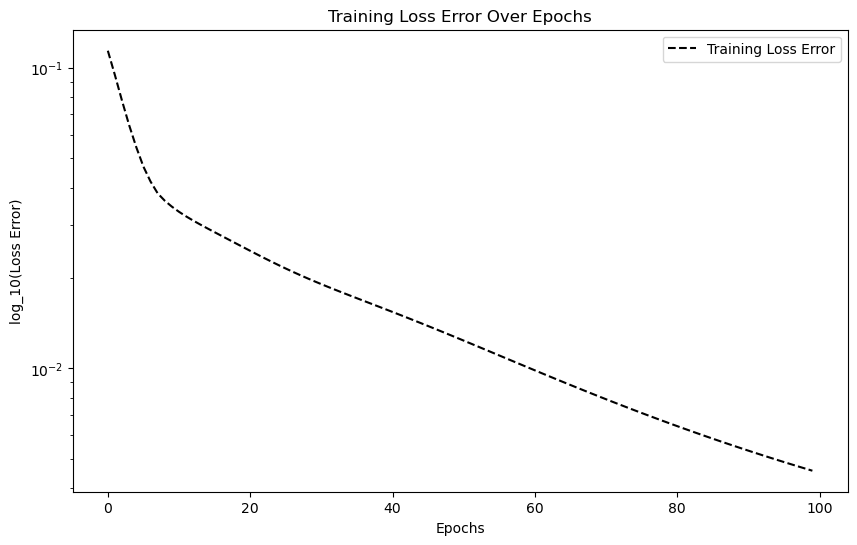

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    range(len(training_loss_error)),
    training_loss_error,
    linestyle="--",
    color="k",
    label="Training Loss Error",
)
ax.set_title("Training Loss Error Over Epochs")
ax.set_xlabel("Epochs")
ax.set_ylabel("log_10(Loss Error)")
# default log scale is log based 10, which asks 10^x = y
# takes in the y values does log10(y), or 10^x = y
ax.set_yscale("log")
ax.legend()
# fig.savefig("train-loss.pdf", format="pdf", bbox_inches="tight")